In [461]:
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [462]:
df = pd.read_csv('data/Data4Good_Arolsen_Archives_50k.csv')
# df = df.sample(n=3000, random_state=42).reset_index(drop=True)
df_init = df.copy()

In [463]:
pd.set_option('display.max_columns', None)

In [464]:
df.columns

Index(['Unnamed: 0', 'Last_Name', 'First Name', 'Alternative Name',
       'Father (Vater - Eltern)', 'Mother (Mutter - Eltern)',
       'Spouse (Ehem/Ehefr)', 'Birthdate (Geb)', 'Alternative_Birthdate',
       'Birth Place', 'TD', 'Nationality', 'Alternative Nationality 1',
       'Alternative Nationality 2', 'Religion', 'Upper', 'Middle',
       'Geo Location', 'Inferred Nationality', 'Overall Confidence OCR',
       'Automatic Validation', 'Volunteers' Comment'],
      dtype='object')

In [465]:
# Ensure all values are strings and replace double double-quotes
df["Geo Location"] = df["Geo Location"].astype(str).apply(lambda x: x.replace('""', '"'))
# Ensure values are strings and remove surrounding quotes
df["Geo Location"] = df["Geo Location"].astype(str).apply(lambda x: x.strip('"'))
# Ensure values are strings and remove surrounding single and double quotes
df["Geo Location"] = df["Geo Location"].astype(str).apply(lambda x: x.strip("'").strip('"'))

df_init["Geo Location"] = df["Geo Location"].astype(str).apply(lambda x: x.replace('""', '"'))
df_init["Geo Location"] = df["Geo Location"].astype(str).apply(lambda x: x.strip('"'))
df_init["Geo Location"] = df["Geo Location"].astype(str).apply(lambda x: x.strip("'").strip('"'))



In [466]:
import json

# Dictionary to store cluster to city mappings
cluster_to_city = {}

# Function to extract cluster information from JSON
def extract_cluster_info(json_data):
    try:
        data = json.loads(json_data)  # Parse JSON
        for marker in data.get("markers", []):
            if "location" in marker and "label" in marker:
                lat, lon = marker["location"]["lat"], marker["location"]["lon"]
                city = marker["label"]
                cluster_id = (lat, lon)  # Use lat/lon as a unique cluster key
                if cluster_id not in cluster_to_city:
                    cluster_to_city[cluster_id] = {"city": city, "lat": lat, "lon": lon}
    except json.JSONDecodeError:
        pass  # Skip invalid JSON

# Apply function to extract data
df["Geo Location"].dropna().apply(extract_cluster_info)

# Convert cluster_to_city mapping to the desired format
structured_mapping = {data["city"]: {"lat": lat, "lon": lon} for (lat, lon), data in cluster_to_city.items()}

# Print the structured mapping
# print(json.dumps(structured_mapping, indent=4))

# Optionally, save it as a dictionary for use in predictions
city_location_mapping = structured_mapping



In [467]:
# import json
# import pandas as pd

# # Function to safely extract max index
# def get_max_index(json_str):
#     try:
#         data = json.loads(json_str)
#         paths = data.get("paths", [])
#         if paths:  # Ensure paths is not empty
#             return max(item["index"] for item in paths)
#         return -1  # Return -1 if paths is empty
#     except (json.JSONDecodeError, KeyError, TypeError):
#         return -1  # Return -1 if the structure is invalid

# Apply function to DataFrame
# df["max_index"] = df["Geo Location"].apply(get_max_index)

In [468]:
df.columns

Index(['Unnamed: 0', 'Last_Name', 'First Name', 'Alternative Name',
       'Father (Vater - Eltern)', 'Mother (Mutter - Eltern)',
       'Spouse (Ehem/Ehefr)', 'Birthdate (Geb)', 'Alternative_Birthdate',
       'Birth Place', 'TD', 'Nationality', 'Alternative Nationality 1',
       'Alternative Nationality 2', 'Religion', 'Upper', 'Middle',
       'Geo Location', 'Inferred Nationality', 'Overall Confidence OCR',
       'Automatic Validation', 'Volunteers' Comment'],
      dtype='object')

In [469]:
df = df.drop(columns=["Unnamed: 0", "Last_Name", "First Name", "TD", "Alternative Name", "Father (Vater - Eltern)", "Mother (Mutter - Eltern)", "Spouse (Ehem/Ehefr)", "Upper", "Middle", "Volunteers' Comment", "Overall Confidence OCR", "Alternative Nationality 2", "Alternative Nationality 1"])

# Convert to string to avoid errors
df['Birthdate (Geb)'] = df['Birthdate (Geb)'].astype(str)

# Function to split birthdate into components
def split_birthdate(date):
    if date.startswith('//'):  # Case: Birthdate starts with "//"
        return date[2:], np.nan, np.nan  # Extract year, set Month and Day to 0
    
    parts = date.split('/')
    
    if len(parts) == 3:  # Full date case (DD/MM/YYYY)
        return parts[2], parts[1], parts[0]  # Year, Month, Day
    elif len(parts) == 1 and date.isdigit() and len(date) == 4:  # Year only (YYYY)
        return date, np.nan, np.nan  # Set Month and Day to 0
    else:
        return None, None, None  # Handle missing or invalid values

# Apply function to create new columns
df[['Birth_Year', 'Birth_Month', 'Birth_Day']] = df['Birthdate (Geb)'].apply(lambda x: pd.Series(split_birthdate(x)))

# Convert numeric columns to integers where possible
df['Birth_Year'] = pd.to_numeric(df['Birth_Year'], errors='coerce')
df['Birth_Month'] = pd.to_numeric(df['Birth_Month'], errors='coerce')
df['Birth_Day'] = pd.to_numeric(df['Birth_Day'], errors='coerce')

df['Birth_Month'] = np.where(df['Birth_Month'] > 12, np.nan, df['Birth_Month'])
df['Birth_Day'] = np.where(df['Birth_Day'] > 31, np.nan, df['Birth_Day'])    

df['Birth_Year'] = np.where(df['Birth_Year'] < 1800, np.nan, df['Birth_Year'])
df['Birth_Year'] = np.where(df['Birth_Year'] > 1945, np.nan, df['Birth_Year'])

df.drop(columns=['Birthdate (Geb)', 'Alternative_Birthdate'], inplace=True)

df['Religion'] = df['Religion'].replace({
    'Orthodox Christian Christian Christian Christian Christian': 'Orthodox Christian'
})

# Group rare religions
min_count = 5  # Threshold for rare categories
religion_counts = df['Religion'].value_counts()
rare_religions = religion_counts[religion_counts < min_count].index
df['Religion'] = df['Religion'].replace(rare_religions, 'Other')

df = pd.get_dummies(df, columns=['Religion'], prefix='Religion')
print(df.columns)

# Convert boolean columns to integers
religion_columns = [col for col in df.columns if col.startswith('Religion_')]
df[religion_columns] = df[religion_columns].astype(int)

df['Automatic Validation'].isna().sum()
df['Automatic Validation'] = df['Automatic Validation'].fillna('Unknown')


Index(['Birth Place', 'Nationality', 'Geo Location', 'Inferred Nationality',
       'Automatic Validation', 'Birth_Year', 'Birth_Month', 'Birth_Day',
       'Religion_Evangelical Christian', 'Religion_Jewish',
       'Religion_Orthodox Christian', 'Religion_Other',
       'Religion_Roman Catholic'],
      dtype='object')


In [470]:
df["Nationality"] = df["Nationality"].str.replace(r"(?i)\bFormerly\b", "", regex=True).str.strip()

df["Nationality"] = df["Nationality"].str.lower().replace(r"stateless", np.nan, regex=True)

from fuzzywuzzy import process
import pandas as pd

# Convert valid nationalities list to lowercase
valid_nationalities = [
    # Common nationalities (ISO 3166)
    "afghan", "albanian", "algerian", "american", "andorran", "angolan", "argentine", "armenian", "australian", "austrian",
    "azerbaijani", "bahamian", "bahraini", "bangladeshi", "barbadian", "belarusian", "belgian", "belizean", "beninese", "bhutanese",
    "bolivian", "bosnian", "botswanan", "brazilian", "british", "bruneian", "bulgarian", "burkinabé", "burmese", "burundian",
    "cambodian", "cameroonian", "canadian", "cape verdean", "central african", "chadian", "chilean", "chinese", "colombian",
    "comoran", "congolese", "costa rican", "croatian", "cuban", "cypriot", "czech", "danish", "djiboutian", "dominican",
    "dutch", "east timorese", "ecuadorean", "egyptian", "emirati", "equatorial guinean", "eritrean", "estonian", "eswatini",
    "ethiopian", "fijian", "finnish", "french", "gabonese", "gambian", "georgian", "german", "ghanaian", "greek",
    "grenadian", "guatemalan", "guinean", "guyanese", "haitian", "honduran", "hungarian", "icelandic", "indian", "indonesian",
    "iranian", "iraqi", "irish", "israeli", "italian", "ivorian", "jamaican", "japanese", "jordanian", "kazakh",
    "kenyan", "kiribati", "kuwaiti", "kyrgyz", "lao", "latvian", "lebanese", "lesotho", "liberian", "libyan",
    "liechtensteiner", "lithuanian", "luxembourgish", "macedonian", "malagasy", "malawian", "malaysian", "maldivian",
    "malian", "maltese", "marshallese", "mauritanian", "mauritian", "mexican", "micronesian", "moldovan", "monacan",
    "mongolian", "montenegrin", "moroccan", "mozambican", "myanmar", "namibian", "nauruan", "nepalese", "new zealander",
    "nicaraguan", "nigerian", "north korean", "norwegian", "omani", "pakistani", "palauan", "palestinian", "panamanian",
    "papua new guinean", "paraguayan", "peruvian", "philippine", "polish", "portuguese", "qatari", "romanian", "russian",
    "rwandan", "saint lucian", "salvadoran", "samoan", "saudi", "scottish", "senegalese", "serbian", "seychellois",
    "sierra leonean", "singaporean", "slovak", "slovenian", "solomon islander", "somali", "south african", "south korean",
    "south sudanese", "spanish", "sri lankan", "sudanese", "surinamese", "swedish", "swiss", "syrian", "taiwanese",
    "tajik", "tanzanian", "thai", "togolese", "tongan", "trinidadian", "tunisian", "turkish", "turkmen", "tuvaluan",
    "ugandan", "ukrainian", "uruguayan", "uzbek", "venezuelan", "vietnamese", "welsh", "yemeni", "zambian", "zimbabwean",

    # Historical nationalities
    "austro-hungarian", "prussian", "bohemian", "ottoman", "soviet", "yugoslav", "czechoslovak", "west german", "east german",
    "rhodesian", "serbo-croatian", "mandarin", "manchu", "ming", "byzantine",

    # Stateless or refugee identities
    "stateless", "refugee", "displaced", "unknown",

    # Manually added for necessity
    "yugoslavian", "ussr"
]

# Manual correction mapping for specific cases
manual_corrections = {
    "argentinian": "argentine",
    "luxembourger": "luxembourgish",
    "germna": "german",  # Common OCR mistake
    "polan": "polish"  # Common OCR mistake
}

# Convert all nationalities in data to lowercase and strip spaces
df["Nationality"] = df["Nationality"].str.lower().str.strip()

# Apply manual corrections first
df["Nationality_Corrected"] = df["Nationality"].replace(manual_corrections)

# Fuzzy matching function for remaining uncorrected values
def fuzzy_correct(nationality):
    if pd.isna(nationality):  # Skip NaN values
        return None
    match, score = process.extractOne(nationality, valid_nationalities)
    return match if score > 85 else nationality  # Keep original if match is weak

In [471]:
df.columns

Index(['Birth Place', 'Nationality', 'Geo Location', 'Inferred Nationality',
       'Automatic Validation', 'Birth_Year', 'Birth_Month', 'Birth_Day',
       'Religion_Evangelical Christian', 'Religion_Jewish',
       'Religion_Orthodox Christian', 'Religion_Other',
       'Religion_Roman Catholic', 'Nationality_Corrected'],
      dtype='object')

In [472]:
# Apply fuzzy matching for remaining uncorrected values
df["Nationality_Corrected"] = df["Nationality_Corrected"].apply(fuzzy_correct)

# Identify cases where fuzzy matching changed the nationality
data_fuzzy_changed = df[df["Nationality"] != df["Nationality_Corrected"]]

# Print fuzzy-matched values
# print("Fuzzy-matched corrections:")
# print(data_fuzzy_changed[["Nationality", "Nationality_Corrected"]])

# Identify remaining unrecognized nationalities
unrecognized = df[~df["Nationality_Corrected"].isin(valid_nationalities)]
# print("\nRemaining Unrecognized Nationalities:")
# print(unrecognized["Nationality_Corrected"].unique())

# Find nationalities not in the valid list
valid_nationalities.append(None)
data_unrecognized = df[~df["Nationality_Corrected"].isin(valid_nationalities)]
# Show the indexes and the unrecognized nationalities
df = df[~df["Nationality_Corrected"].isin(data_unrecognized['Nationality_Corrected'])].reset_index(drop=True)

df.drop(columns=['Nationality', 'Inferred Nationality'], inplace=True)

In [473]:
from sklearn.preprocessing import LabelEncoder

# Fill None values with "unknown"
df["Nationality_Corrected"] = df["Nationality_Corrected"].fillna("unknown")

# Apply Label Encoding
label_encoder = LabelEncoder()
df["Nationality_Corrected_Encoded"] = label_encoder.fit_transform(df["Nationality_Corrected"])

df.drop(columns=['Nationality_Corrected'], inplace=True)

# Impute missing values with the mean of each column
df["Birth_Year"].fillna(df["Birth_Year"].mean(), inplace=True)
df["Birth_Month"].fillna(df["Birth_Month"].mean(), inplace=True)
df["Birth_Day"].fillna(df["Birth_Day"].mean(), inplace=True)

# Convert Birth_Year to integer (optional if you don't want decimals)
df["Birth_Year"] = df["Birth_Year"].round().astype(int)
df["Birth_Month"] = df["Birth_Month"].round().astype(int)
df["Birth_Day"] = df["Birth_Day"].round().astype(int)

# Define a mapping to ensure a consistent order
validation_mapping = {
    "Unknown": 4,
    "Matched": 3,
    "Above threshold for Last Name and TD": 2,
    "To be validated": 1,
    "Submitted": 0
}

# Apply mapping to encode the column
df["Automatic_Validation_Encoded"] = df["Automatic Validation"].map(validation_mapping).round().astype(int)
df.drop(columns=['Automatic Validation'], inplace=True)



C:\Users\Rusel\AppData\Local\Temp\ipykernel_1104\861608131.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Birth_Year"].fillna(df["Birth_Year"].mean(), inplace=True)
C:\Users\Rusel\AppData\Local\Temp\ipykernel_1104\861608131.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a co

In [474]:
df

,Birth Place,Geo Location,Birth_Year,Birth_Month,Birth_Day,Religion_Evangelical Christian,Religion_Jewish,Religion_Orthodox Christian,Religion_Other,Religion_Roman Catholic,Nationality_Corrected_Encoded,Automatic_Validation_Encoded
0,Wiekowo,"{""paths"":[{""fromLabel"":""Wiekowo"",""toLabel"":""We...",1926,7,29,0,0,0,0,1,44,2
1,Laszczow Polen,"{""paths"":[{""fromLabel"":""Laszczow Polen"",""toLab...",1925,10,10,0,0,0,0,0,62,3
2,Biala Österr,"{""paths"":[{""fromLabel"":""Biala Österr"",""toLabel...",1904,11,12,0,0,0,0,0,62,1
3,Warschau,"{""paths"":[{""fromLabel"":""Warschau"",""toLabel"":""W...",1913,6,15,0,1,0,0,0,44,3
4,Einsiedl Böhmen,"{""paths"":[{""fromLabel"":""Einsiedl Böhmen"",""toLa...",1894,5,27,0,0,0,0,0,26,2
...,...,...,...,...,...,...,...,...,...,...,...,...
49423,Lomza,"{""paths"":[{""fromLabel"":""Lomza"",""toLabel"":""Pari...",1896,2,22,0,0,0,0,0,62,3
49424,Czarnowits,"{""paths"":[{""fromLabel"":""Czarnowits"",""toLabel"":...",1885,10,7,0,0,0,0,0,62,1
49425,Amsterdam,"{""paths"":[{""fromLabel"":""Amsterdam"",""toLabel"":""...",1921,1,17,0,1,0,0,0,62,3
49426,Mates zalka,"{""paths"":[{""fromLabel"":""Mates zalka"",""toLabel""...",1930,1,18,0,1,0,0,0,15,1


In [475]:
from sklearn.cluster import DBSCAN
import folium
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# **Step 1: Refine DBSCAN Parameters**
dbscan_eps = 0.04  # Adjusted radius (~4km)
dbscan_min_samples = 2  # Allow smaller but meaningful clusters
dbscan = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples, metric="haversine").fit(np.radians(geo_array))
dbscan_clusters = dbscan.labels_

# **Step 2: Refine K-Means Parameters**
num_clusters = min(len(geo_array), 500)  # Moderate number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans_clusters = kmeans.fit_predict(geo_array)

# **Step 3: Adaptive Radii for K-Means**
adaptive_radii = []
for i in range(num_clusters):
    cluster_size = np.sum(kmeans_clusters == i)
    adaptive_radii.append(max(20000, 80000 / np.sqrt(cluster_size)))  # Minimum radius 20km

# **Step 4: Visualize Results**
m = folium.Map(location=map_center, zoom_start=6)

# Plot DBSCAN Clusters (Blue for clustered points, Red for noise)
for (lat, lon), cluster in zip(geo_array, dbscan_clusters):
    color = "red" if cluster == -1 else "blue"
    folium.CircleMarker(
        location=[lat, lon],
        radius=4,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.6,
        popup=f"DBSCAN Cluster {cluster}" if cluster != -1 else "Noise"
    ).add_to(m)

# Plot K-Means Clusters (Green Circles for areas, Red Markers for centers)
for i, center in enumerate(kmeans.cluster_centers_):
    folium.Circle(
        location=[center[0], center[1]],
        radius=adaptive_radii[i],
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.3,
        popup=f"K-Means Cluster Area (Radius: {int(adaptive_radii[i])}m)"
    ).add_to(m)

# Add K-Means Cluster Centers
for center in kmeans.cluster_centers_:
    folium.Marker(
        location=[center[0], center[1]],
        icon=folium.Icon(color="red", icon="info-sign"),
        popup="K-Means Cluster Center"
    ).add_to(m)

# Display the map
# m


In [476]:
# Assign DBSCAN and K-Means cluster labels to df['Geo Location']
import json

# Function to assign DBSCAN clusters to each person's locations
def assign_dbscan_clusters(json_data, dbscan_clusters, geo_array):
    try:
        data = json.loads(json_data)  # Parse JSON
        clusters = []
        for marker in data.get("markers", []):
            if "location" in marker:
                lat, lon = marker["location"]["lat"], marker["location"]["lon"]
                idx = np.where((geo_array == [lat, lon]).all(axis=1))[0]
                if len(idx) > 0:
                    clusters.append(dbscan_clusters[idx[0]])
                else:
                    clusters.append(-1)  # Noise point
        return clusters
    except json.JSONDecodeError:
        return []

# Function to assign K-Means clusters to each person's locations
def assign_kmeans_clusters(json_data, kmeans, geo_array):
    try:
        data = json.loads(json_data)  # Parse JSON
        clusters = []
        for marker in data.get("markers", []):
            if "location" in marker:
                lat, lon = marker["location"]["lat"], marker["location"]["lon"]
                clusters.append(kmeans.predict([[lat, lon]])[0])
        return clusters
    except json.JSONDecodeError:
        return []


# Assign K-Means clusters
df["KMeans_Clusters"] = df["Geo Location"].apply(lambda x: assign_kmeans_clusters(x, kmeans, geo_array))
df.drop(columns=['Geo Location', 'Birth Place'], inplace=True)


In [477]:
df

,Birth_Year,Birth_Month,Birth_Day,Religion_Evangelical Christian,Religion_Jewish,Religion_Orthodox Christian,Religion_Other,Religion_Roman Catholic,Nationality_Corrected_Encoded,Automatic_Validation_Encoded,KMeans_Clusters
0,1926,7,29,0,0,0,0,1,44,2,"[302, 320, 39, 39, 302]"
1,1925,10,10,0,0,0,0,0,62,3,"[340, 340, 88]"
2,1904,11,12,0,0,0,0,0,62,1,"[221, 194, 306, 197, 193, 13]"
3,1913,6,15,0,1,0,0,0,44,3,"[96, 96, 96, 96]"
4,1894,5,27,0,0,0,0,0,26,2,"[309, 252, 227]"
...,...,...,...,...,...,...,...,...,...,...,...
49423,1896,2,22,0,0,0,0,0,62,3,"[491, 58, 39]"
49424,1885,10,7,0,0,0,0,0,62,1,"[30, 30, 30, 32, 32, 30, 94, 94]"
49425,1921,1,17,0,1,0,0,0,62,3,"[194, 207, 366, 219, 24, 4]"
49426,1930,1,18,0,1,0,0,0,15,1,"[337, 337, 15, 173, 173, 4]"


In [478]:
# Determine the maximum number of clusters any person has
max_stops = df["KMeans_Clusters"].apply(len).max()

# Set a reasonable maximum number of cluster columns
max_columns = min(max_stops, 10)  # Limit to 10 columns, even if max_stops > 10

# Create columns for each cluster (up to max_columns)
for i in range(max_columns):
    df[f"Cluster_{i+1}"] = df["KMeans_Clusters"].apply(lambda x: x[i] if i < len(x) else np.nan)

# Fill NaN values with a default "No Cluster" placeholder (-1)
for i in range(max_columns):
    df[f"Cluster_{i+1}"].fillna(-1, inplace=True)

# Drop the original KMeans_Clusters column (optional)
df.drop(columns=["KMeans_Clusters"], inplace=True)



C:\Users\Rusel\AppData\Local\Temp\ipykernel_1104\1330793289.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[f"Cluster_{i+1}"].fillna(-1, inplace=True)


In [479]:
df

,Birth_Year,Birth_Month,Birth_Day,Religion_Evangelical Christian,Religion_Jewish,Religion_Orthodox Christian,Religion_Other,Religion_Roman Catholic,Nationality_Corrected_Encoded,Automatic_Validation_Encoded,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,Cluster_10
0,1926,7,29,0,0,0,0,1,44,2,302.0,320.0,39.0,39.0,302.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,1925,10,10,0,0,0,0,0,62,3,340.0,340.0,88.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,1904,11,12,0,0,0,0,0,62,1,221.0,194.0,306.0,197.0,193.0,13.0,-1.0,-1.0,-1.0,-1.0
3,1913,6,15,0,1,0,0,0,44,3,96.0,96.0,96.0,96.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,1894,5,27,0,0,0,0,0,26,2,309.0,252.0,227.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49423,1896,2,22,0,0,0,0,0,62,3,491.0,58.0,39.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
49424,1885,10,7,0,0,0,0,0,62,1,30.0,30.0,30.0,32.0,32.0,30.0,94.0,94.0,-1.0,-1.0
49425,1921,1,17,0,1,0,0,0,62,3,194.0,207.0,366.0,219.0,24.0,4.0,-1.0,-1.0,-1.0,-1.0
49426,1930,1,18,0,1,0,0,0,15,1,337.0,337.0,15.0,173.0,173.0,4.0,-1.0,-1.0,-1.0,-1.0


In [480]:
def get_next_cluster_and_update(row):
    # Extract the list of clusters for a person
    clusters = row[[f"Cluster_{i+1}" for i in range(10)]].tolist()
    
    # Find the last valid cluster before the first -1
    for i in range(len(clusters) - 1, -1, -1):  # Reverse loop
        if clusters[i] != -1:
            # Set this cluster as the next cluster
            next_cluster = clusters[i]
            # Replace this cluster with -1 in the sequence
            clusters[i] = -1
            # Update the row with modified cluster sequence
            for j in range(len(clusters)):
                row[f"Cluster_{j+1}"] = clusters[j]
            return next_cluster  # Return the next cluster
    
    return np.nan  # If no valid cluster exists

# Apply the function to create the target variable and update clusters
df["Next_Cluster"] = df.apply(get_next_cluster_and_update, axis=1)

# Drop rows with no valid target (optional)
df = df.dropna(subset=["Next_Cluster"])

# Ensure Next_Cluster is an integer
df["Next_Cluster"] = df["Next_Cluster"].astype(int)


C:\Users\Rusel\AppData\Local\Temp\ipykernel_1104\876927351.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Next_Cluster"] = df["Next_Cluster"].astype(int)


In [481]:
df

,Birth_Year,Birth_Month,Birth_Day,Religion_Evangelical Christian,Religion_Jewish,Religion_Orthodox Christian,Religion_Other,Religion_Roman Catholic,Nationality_Corrected_Encoded,Automatic_Validation_Encoded,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,Cluster_10,Next_Cluster
0,1926,7,29,0,0,0,0,1,44,2,302.0,320.0,39.0,39.0,302.0,-1.0,-1.0,-1.0,-1.0,-1.0,302
1,1925,10,10,0,0,0,0,0,62,3,340.0,340.0,88.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,88
2,1904,11,12,0,0,0,0,0,62,1,221.0,194.0,306.0,197.0,193.0,13.0,-1.0,-1.0,-1.0,-1.0,13
3,1913,6,15,0,1,0,0,0,44,3,96.0,96.0,96.0,96.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,96
4,1894,5,27,0,0,0,0,0,26,2,309.0,252.0,227.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49423,1896,2,22,0,0,0,0,0,62,3,491.0,58.0,39.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,39
49424,1885,10,7,0,0,0,0,0,62,1,30.0,30.0,30.0,32.0,32.0,30.0,94.0,94.0,-1.0,-1.0,94
49425,1921,1,17,0,1,0,0,0,62,3,194.0,207.0,366.0,219.0,24.0,4.0,-1.0,-1.0,-1.0,-1.0,4
49426,1930,1,18,0,1,0,0,0,15,1,337.0,337.0,15.0,173.0,173.0,4.0,-1.0,-1.0,-1.0,-1.0,4


  0%|          | 0/3 [00:00<?, ?trial/s, best loss=?]

C:\Users\Rusel\AppData\Local\Temp\ipykernel_1104\461845477.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Next_Cluster"] = le.fit_transform(df["Next_Cluster"])
c:\Users\Rusel\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [22:55:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  lib_paths = find_lib_path()

c:\Users\Rusel\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [22:55:31]

 33%|███▎      | 1/3 [04:39<09:18, 279.27s/trial, best loss: -0.6960076449352304]

c:\Users\Rusel\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [23:00:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  lib_paths = find_lib_path()

c:\Users\Rusel\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [23:00:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  lib_paths = find_lib_path()

c:\Users\Rusel\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [23:04:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling

 67%|██████▋   | 2/3 [09:08<04:33, 273.35s/trial, best loss: -0.6960076449352304]

c:\Users\Rusel\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [23:04:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  lib_paths = find_lib_path()

c:\Users\Rusel\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [23:04:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  lib_paths = find_lib_path()

c:\Users\Rusel\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [23:08:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling

100%|██████████| 3/3 [13:20<00:00, 266.71s/trial, best loss: -0.6960076449352304]


c:\Users\Rusel\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [23:08:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  lib_paths = find_lib_path()
c:\Users\Rusel\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [23:08:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  lib_paths = find_lib_path()
c:\Users\Rusel\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [23:13:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-g

XGBoost Accuracy: 0.6960076449352304
XGBoost F1 Score (Macro): 0.3322235509161774
XGBoost Top-5 Accuracy: 0.8542153323423232
              precision    recall  f1-score   support

           0       0.50      0.12      0.20         8
           1       0.00      0.00      0.00         2
           2       0.68      0.88      0.77       123
           3       0.45      0.25      0.32        20
           4       0.76      0.95      0.85       153
           5       0.00      0.00      0.00         1
           6       0.86      0.99      0.92       287
           7       0.80      0.98      0.88       371
           8       0.00      0.00      0.00         6
           9       0.50      0.25      0.33         4
          10       0.67      0.21      0.32        19
          11       0.70      1.00      0.83        19
          12       0.75      0.62      0.68        29
          13       0.80      0.99      0.88       592
          14       0.86      0.32      0.46        19
          

c:\Users\Rusel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Rusel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Rusel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

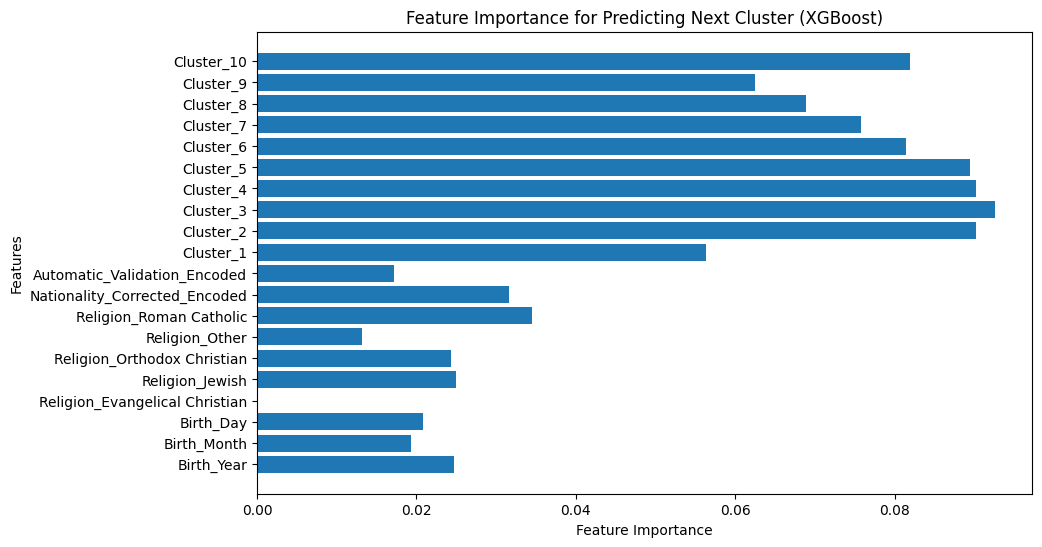

In [487]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, top_k_accuracy_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

# 1️⃣ **Handling -1 Values Properly**
numerical_features = [col for col in df.columns if col.startswith("Cluster_")]
df.loc[:, numerical_features] = df[numerical_features].replace(-1, np.nan)
df.loc[:, numerical_features] = df[numerical_features].fillna(df[numerical_features].mean())

# 2️⃣ **Feature Scaling (Min-Max Normalization)**
scaler = MinMaxScaler()
df.loc[:, numerical_features] = scaler.fit_transform(df[numerical_features])

# 3️⃣ **Fix Class Label Issue (Ensure Continuous Encoding)**
le = LabelEncoder()
df["Next_Cluster"] = le.fit_transform(df["Next_Cluster"])

# 4️⃣ **Filter Out Classes with Only 1 Instance (To Avoid Stratification Error)**
cluster_counts = df["Next_Cluster"].value_counts()
min_samples_threshold = 2
valid_clusters = cluster_counts[cluster_counts >= min_samples_threshold].index

df_main = df[df["Next_Cluster"].isin(valid_clusters)]  # Keep frequent clusters
df_rare = df[~df["Next_Cluster"].isin(valid_clusters)]  # Keep rare clusters only for training

# 5️⃣ **Define Features & Target (Using Full Data)**
features = [col for col in df.columns if col.startswith("Cluster_") or not col.endswith("Next_Cluster")]
X_main = df_main[features]
y_main = df_main["Next_Cluster"]

# 6️⃣ **Train-Test Split (Avoiding Single-Instance Classes)**
X_train, X_test, y_train, y_test = train_test_split(
    X_main, y_main, test_size=0.2, random_state=42, stratify=y_main
)

# Add rare clusters **only to training set**
X_train = pd.concat([X_train, df_rare[features]], ignore_index=True)
y_train = pd.concat([y_train, df_rare["Next_Cluster"]], ignore_index=True)

# 7️⃣ **Narrowed Hyperparameter Search with Hyperopt**
def objective(params):
    """Objective function for Hyperopt"""
    model = XGBClassifier(
        objective="multi:softprob", eval_metric="mlogloss", use_label_encoder=False,
        tree_method="gpu_hist", device="cuda",  # Use GPU for faster training
        n_estimators=int(params["n_estimators"]),
        max_depth=int(params["max_depth"]),
        learning_rate=params["learning_rate"],
        subsample=params["subsample"],
        colsample_bytree=params["colsample_bytree"],
        early_stopping_rounds=10  # Stops early if no improvement
    )
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    y_pred = model.predict(X_test)
    return {"loss": -accuracy_score(y_test, y_pred), "status": STATUS_OK}

# **Narrowed search range based on previous best params**
space = {
    "n_estimators": hp.quniform("n_estimators", 160, 180, 5),  # Previously 170
    "max_depth": hp.quniform("max_depth", 5, 7, 1),  # Previously 6
    "learning_rate": hp.uniform("learning_rate", 0.05, 0.07),  # Previously 0.0595
    "subsample": hp.uniform("subsample", 0.75, 0.8),  # Previously 0.769
    "colsample_bytree": hp.uniform("colsample_bytree", 0.88, 0.91),  # Previously 0.8999
}

# Run optimization (Reduce `max_evals` for speed)
trials = Trials()
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=3, trials=trials)

# Convert best_params to correct types
best_params["n_estimators"] = int(best_params["n_estimators"])
best_params["max_depth"] = int(best_params["max_depth"])

# 8️⃣ **Train Best XGBoost Model with GPU**
xgb_model = XGBClassifier(
    objective="multi:softprob", eval_metric="mlogloss", use_label_encoder=False,
    tree_method="gpu_hist", device="cuda",  # Use GPU
    **best_params
)
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# 🔟 **Fix Top-K Accuracy Issue (Ensure Matching Class Counts)**
known_classes = np.unique(np.concatenate([y_train, y_test]))  # Ensure both sets have same class labels
y_pred_proba = xgb_model.predict_proba(X_test)

# 🔟 **Predictions & Evaluation**
y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGBoost F1 Score (Macro):", f1_score(y_test, y_pred_xgb, average="macro"))
print("XGBoost Top-5 Accuracy:", top_k_accuracy_score(y_test, y_pred_proba, k=5, labels=known_classes))  # Fix class mismatch
print(classification_report(y_test, y_pred_xgb))

# 🔟 **Feature Importance**
importances = xgb_model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance for Predicting Next Cluster (XGBoost)")
plt.show()


In [488]:
best_params

{'colsample_bytree': 0.8967298122739948,
 'learning_rate': 0.057147001016130655,
 'max_depth': 6,
 'n_estimators': 165,
 'subsample': 0.7844820269525442}

In [486]:
len(city_location_mapping)

22097

In [ ]:
df

,Birth_Year,Birth_Month,Birth_Day,Religion_Evangelical Christian,Religion_Jewish,Religion_Orthodox Christian,Religion_Other,Religion_Roman Catholic,Nationality_Corrected_Encoded,Automatic_Validation_Encoded,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,Cluster_10,Next_Cluster,Prediction_JSON
0,1926,7,29,0,0,0,0,1,44,2,302.0,320.0,39.0,39.0,302.0,-1.0,-1.0,-1.0,-1.0,-1.0,302,None
1,1925,10,10,0,0,0,0,0,62,3,340.0,340.0,88.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,88,None
2,1904,11,12,0,0,0,0,0,62,1,221.0,194.0,306.0,197.0,193.0,13.0,-1.0,-1.0,-1.0,-1.0,13,None
3,1913,6,15,0,1,0,0,0,44,3,96.0,96.0,96.0,96.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,96,None
4,1894,5,27,0,0,0,0,0,26,2,309.0,252.0,227.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,227,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49423,1896,2,22,0,0,0,0,0,62,3,491.0,58.0,39.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,39,None
49424,1885,10,7,0,0,0,0,0,62,1,30.0,30.0,30.0,32.0,32.0,30.0,94.0,94.0,-1.0,-1.0,94,None
49425,1921,1,17,0,1,0,0,0,62,3,194.0,207.0,366.0,219.0,24.0,4.0,-1.0,-1.0,-1.0,-1.0,4,None
49426,1930,1,18,0,1,0,0,0,15,1,337.0,337.0,15.0,173.0,173.0,4.0,-1.0,-1.0,-1.0,-1.0,4,None


In [561]:
import folium
import random
import json
from geopy.distance import geodesic

# Select a specific person (e.g., row index 1000)
df["Geo Location"] = df_init["Geo Location"]
first_person = df.iloc[11]

# Load original confirmed locations from 'Geo Location'
geo_data = json.loads(first_person["Geo Location"])

# Extract confirmed locations, ensuring 'location' key exists
confirmed_locations = [
    {"city": marker["label"], "lat": marker["location"]["lat"], "lon": marker["location"]["lon"]}
    for marker in geo_data.get("markers", []) if "location" in marker
]

# Extract the predicted next cluster
next_cluster = first_person["Next_Cluster"]

# Calculate city frequencies to weight less common locations
city_frequency = {city: 1 for city in city_location_mapping.keys()}  # Default freq = 1
for city in city_location_mapping.keys():
    city_frequency[city] += 1  # Count occurrences (higher → penalized)

# Function to get multiple nearby valid cities with weighted probability
def get_balanced_prediction(cluster_id, last_known_location, min_distance_km=100, max_distance_km=1500, num_choices=7):
    """
    Finds multiple nearby cities with a weighted probability but ensures
    the predicted step is neither too close nor too far.
    """
    city_options = []

    for city, data in city_location_mapping.items():
        city_coords = (data["lat"], data["lon"])
        try:
            distance = geodesic(last_known_location, city_coords).kilometers
            if min_distance_km <= distance <= max_distance_km:
                # Compute weight: Favor less frequent locations & avoid tiny jumps
                weight = 1 / (city_frequency.get(city, 1) + 1)
                adjusted_weight = weight * ((distance - min_distance_km) / (max_distance_km - min_distance_km + 1))  
                city_options.append((city, data["lat"], data["lon"], distance, adjusted_weight))
        except:
            continue  # Ignore invalid values

    # Sort by distance & select the top `num_choices` closest ones
    city_options = sorted(city_options, key=lambda x: x[3])[:num_choices]

    if not city_options:
        return None  # No valid options

    # Normalize weights for probability selection
    total_weight = sum(city[4] for city in city_options)
    probabilities = [city[4] / total_weight for city in city_options]

    # Select a city using weighted probabilities
    selected_city = random.choices(city_options, weights=probabilities, k=1)[0]
    
    return {"city": selected_city[0], "lat": selected_city[1], "lon": selected_city[2]}

# Ensure we have at least one valid confirmed location
if confirmed_locations:
    map_center = (confirmed_locations[0]["lat"], confirmed_locations[0]["lon"])
    last_location = (confirmed_locations[-1]["lat"], confirmed_locations[-1]["lon"])
else:
    print("⚠️ No confirmed locations found for this person.")
    map_center = (0, 0)
    last_location = (0, 0)  # Default to prevent errors

# Get a more realistic prediction with balanced selection
realistic_prediction = get_balanced_prediction(next_cluster, last_location)

# Create **Folium Map with a Vintage Tile Layer**
m = folium.Map(
    location=map_center,
    zoom_start=6,
    tiles="Stamen Toner",  # WWII-style black and white map
    attr="Stamen Toner (Historical Map)"
)

# 🔹 **Improved Sepia Overlay for Vintage War Look**
sepia_overlay = "https://cdn.pixabay.com/photo/2016/11/13/21/49/background-1822153_1280.jpg"  # High-resolution sepia texture

# folium.raster_layers.ImageOverlay(
#     name="Sepia Tint Overlay",
#     image=sepia_overlay,
#     bounds=[[-85, -180], [85, 180]],  # Expanded for full global coverage
#     opacity=0.4,  # Slightly stronger sepia effect
#     interactive=False
# ).add_to(m)

# 🔹 **Alternative: Tile-Based Overlay for Better Scaling**
folium.TileLayer(
    tiles="https://www.transparenttextures.com/patterns/old-map.png",  # Old map texture
    attr="Old Map Texture",
    name="Sepia War Map",
    overlay=True,
    control=True
).add_to(m)


# 🔹 **Confirmed Locations - Default Dark Red Markers**
for i, point in enumerate(confirmed_locations):
    folium.Marker(
        location=[point["lat"], point["lon"]],
        popup=f"Confirmed Step {i+1}: {point['city']}",
        icon=folium.Icon(color="darkred", icon="info-sign")  # Default marker in dark red
    ).add_to(m)

# 🔹 **Draw Paths with Aged Sepia Colors**
for i in range(len(confirmed_locations) - 1):
    folium.PolyLine(
        [(confirmed_locations[i]["lat"], confirmed_locations[i]["lon"]),
         (confirmed_locations[i+1]["lat"], confirmed_locations[i+1]["lon"])],
        color="#704214",  # Sepia war-map style
        weight=3
    ).add_to(m)

# 🔹 **Predicted Next Step - Flag Icon**
if realistic_prediction:
    folium.Marker(
        location=[realistic_prediction["lat"], realistic_prediction["lon"]],
        popup=f"Predicted Next Step: {realistic_prediction['city']}",
        icon=folium.Icon(color="orange", icon="flag")  # Default flag icon in orange
    ).add_to(m)

    # Draw a dashed **orange line** from the last confirmed stop to the corrected predicted stop
    folium.PolyLine(
        [(confirmed_locations[-1]["lat"], confirmed_locations[-1]["lon"]),
         (realistic_prediction["lat"], realistic_prediction["lon"])],
        color="orange",
        weight=2.5,
        dash_array="5,5"
    ).add_to(m)

# 🔹 **Layer Control: Toggle WWII vs Modern Map**
folium.TileLayer("CartoDB Positron", name="Modern Map").add_to(m)  # Light gray for modern
folium.LayerControl(collapsed=False).add_to(m)  # Control for toggling maps



# ✅ **Final Output: Vintage War Map**
m.save("vintage_war_map.html")
m


C:\Users\Rusel\AppData\Local\Temp\ipykernel_1104\34259270.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Geo Location"] = df_init["Geo Location"]
